# Calculate Gene mC Fractions

In [1]:
import pandas as pd
from ALLCools.mcds import MCDS

In [2]:
from ALLCools.dataset import ALLCoolsDataset

brain_dataset = ALLCoolsDataset('/gale/netapp/cemba3c/projects/ALLCools/Brain/snmC-seq2/')

## Load metadata

In [3]:
gene_meta = pd.read_csv(
    brain_dataset.metadata_dir / 'modified_gencode.vM23.primary_assembly.annotation.gene.flat.tsv.gz',
    index_col='gene_id', sep='\t')

In [5]:
metadata = pd.read_csv(brain_dataset.metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 4875 cells


## Filter genes by cell mean coverage

In [6]:
var_dim = 'geneslop2k-vm23'

Feature geneslop2k-vm23 mean cov across cells added in MCDS.coords['geneslop2k-vm23_cov_mean'].


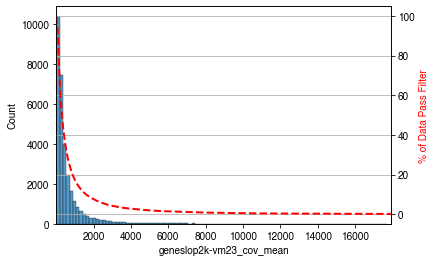

In [8]:
mcds = MCDS.open(brain_dataset.mcds_paths,
                 var_dim=var_dim,
                 use_obs=metadata.index)
mcds.add_feature_cov_mean()

In [9]:
mcds.filter_feature_by_cov_mean(min_cov=5)
mcds.remove_chromosome(exclude_chromosome=['chrM'])

Before cov mean filter: 32208 geneslop2k-vm23
 After cov mean filter: 31451 geneslop2k-vm23 97.6%
13 geneslop2k-vm23 features in ['chrM'] removed.


<xarray.MCDS>
Dimensions:                   (geneslop2k-vm23: 32195, cell: 4875,
                               count_type: 2, mc_type: 2)
Coordinates:
  * geneslop2k-vm23           (geneslop2k-vm23) object 'ENSMUSG00000051951' ....
  * cell                      (cell) <U15 '8E_M_3022' ... '8J_M_2288'
  * count_type                (count_type) <U3 'mc' 'cov'
  * mc_type                   (mc_type) <U3 'CGN' 'CHN'
    geneslop2k-vm23_cov_mean  (geneslop2k-vm23) float64 6.996e+03 ... 0.08287
Data variables:
    geneslop2k-vm23_chrom     (geneslop2k-vm23) <U5 dask.array<chunksize=(2000,), meta=np.ndarray>
    geneslop2k-vm23_da        (cell, geneslop2k-vm23, mc_type, count_type) uint16 dask.array<chunksize=(1000, 2000, 2, 2), meta=np.ndarray>
    geneslop2k-vm23_end       (geneslop2k-vm23) int64 dask.array<chunksize=(2000,), meta=np.ndarray>
    geneslop2k-vm23_start     (geneslop2k-vm23) int64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  geneslop2k-vm23

## Calculate and Save Gene mC Fractions

In [10]:
mcds.add_mc_frac(normalize_per_cell=True, clip_norm_value=10)

In [11]:
# only keep fraction for saving
mcds = mcds[[f'{var_dim}_da_frac']]
mcds[f'{var_dim}_da_frac'] = mcds[f'{var_dim}_da_frac'].astype('float32')

In [12]:
mcds.write_dataset(f'{var_dim}_frac.mcds',
                   var_dims=[var_dim],
                   mode='w',
                   chunks={'cell': 1000, var_dim: 10000})

Saving geneslop2k-vm23
Saving chunk 0: 0 - 1000


/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 1: 1000 - 2000


/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 2: 2000 - 3000


/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 3: 3000 - 4000


/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 4: 4000 - 4875


/home/hanliu/mambaforge/envs/wmb/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


## Save gene metadata together with gene fraction files

In [13]:
use_gene_meta = gene_meta.loc[mcds.var_names]
use_gene_meta.to_csv('GeneMetadata.csv.gz')